In [1]:
import pandas as pd
from pandas import DataFrame
import lxml
! pip install folium
! pip install geopy
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
# Scrape data from given website
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
#Turn array into dataframe
df=df[0]
#keep on rows where Borough is assigned 
df=df[df["Borough"] != "Not assigned"]

df.set_index("Postal Code")
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [3]:
#check that dataframe is as excepected
df.shape

(103, 3)

In [4]:
#create pandas dataframe with latitude and longitude data

lldata=pd.read_csv("http://cocl.us/Geospatial_data")
lldata.set_index("Postal Code")
lldata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
#merge neighborhood data with latitude and longitude data 

toronto_data = pd.merge(df, lldata)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [6]:
#get location data about Toronto

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto neighborhoods")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [16]:
#organize data for clustering
toronto_data_clustering=toronto_data.drop(["Postal Code", "Neighborhood","Borough"], axis=1)


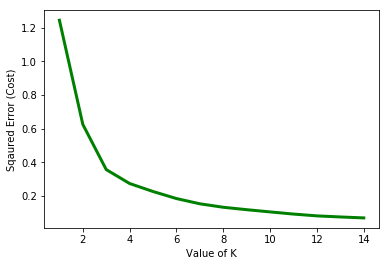

In [17]:
#determine ideal number of clusters for KMeans Clustering Algorithm

cost =[] 
for i in range(1, 15): 
    KM = KMeans(n_clusters = i, max_iter = 300) 
    KM.fit(toronto_data_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [18]:
# set number of clusters
kclusters = 6

toronto_data_clustering=toronto_data.drop(["Postal Code", "Neighborhood","Borough"], axis=1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_data_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 5, 4, 5, 1, 2, 3, 0, 5], dtype=int32)

In [19]:
#Add cluster label to data frame
toronto_data.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_data.head()

,Cluster Labels,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,0,M3A,North York,Parkwoods,43.753259,-79.329656
1,0,M4A,North York,Victoria Village,43.725882,-79.315572
2,5,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,4,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood'], toronto_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters